Requirements

In [ ]:
!pip install laspy
!pip install laspy[lazrs]
!pip install laszip
!pip install open3d

**1. Data Preparation**

Loading and Normalization

In [ ]:
import laspy, numpy as np
las = laspy.read("/content/Site4_1_reference.laz")
points = np.vstack((las.x, las.y, las.z)).T
points -= np.mean(points, axis=0)  # center the cloud


Total points: 771292
X range: -15.168577814882156 to 16.73142218508292
Y range: -52.13784416299313 to 47.64215583726764
Z range: -0.745113951655128 to 0.42488604834486665
Mean height (Z): 1.351786338695255e-14


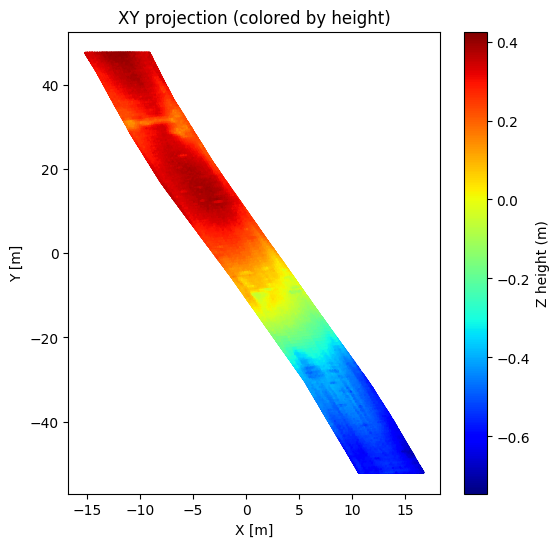

In [ ]:
import laspy, numpy as np, open3d as o3d, matplotlib.pyplot as plt

# --- Load and center ---
las = laspy.read("/content/Site4_1_reference.laz")
points = np.vstack((las.x, las.y, las.z)).T
points -= np.mean(points, axis=0)  # center the cloud

# --- Basic description ---
print("Total points:", len(points))
print("X range:", np.min(points[:,0]), "to", np.max(points[:,0]))
print("Y range:", np.min(points[:,1]), "to", np.max(points[:,1]))
print("Z range:", np.min(points[:,2]), "to", np.max(points[:,2]))
print("Mean height (Z):", np.mean(points[:,2]))

# --- Quick 2D projection (XY view) ---
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=0.2, c=points[:,2], cmap='jet')
plt.title("XY projection (colored by height)")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.colorbar(label='Z height (m)')
plt.show()



Downsampling

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
down_pcd = pcd.voxel_down_sample(voxel_size=0.05)
points = np.asarray(down_pcd.points)

In [ ]:
import numpy as np

# Assuming 'points' = np.asarray(down_pcd.points)
print("Total points after downsampling:", points.shape[0])

# Get coordinate ranges
x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
y_min, y_max = np.min(points[:,1]), np.max(points[:,1])
z_min, z_max = np.min(points[:,2]), np.max(points[:,2])

print(f"X range: {x_min:.3f} to {x_max:.3f}")
print(f"Y range: {y_min:.3f} to {y_max:.3f}")
print(f"Z range: {z_min:.3f} to {z_max:.3f}")
print(f"Mean height (Z): {np.mean(points[:,2]):.3f}")


Total points after downsampling: 321373
X range: -15.169 to 16.721
Y range: -52.138 to 47.642
Z range: -0.735 to 0.425
Mean height (Z): -0.017


Total points after downsampling: 321373
X range: -15.169 to 16.721
Y range: -52.138 to 47.642
Z range: -0.735 to 0.425
Mean height (Z): -0.017


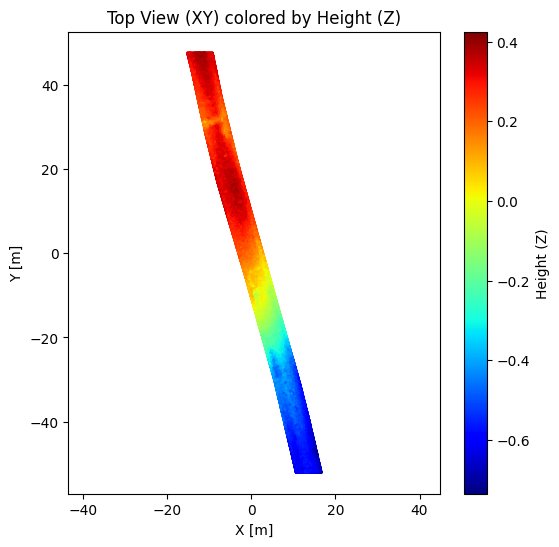

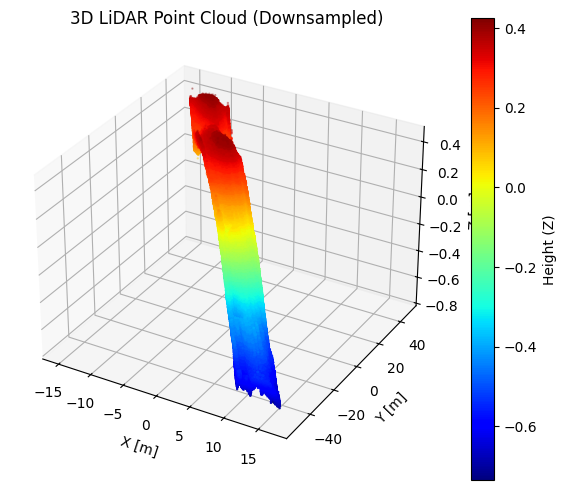

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'points' = np.asarray(down_pcd.points)

# --- Basic stats ---
print("Total points after downsampling:", points.shape[0])
print(f"X range: {np.min(points[:,0]):.3f} to {np.max(points[:,0]):.3f}")
print(f"Y range: {np.min(points[:,1]):.3f} to {np.max(points[:,1]):.3f}")
print(f"Z range: {np.min(points[:,2]):.3f} to {np.max(points[:,2]):.3f}")
print(f"Mean height (Z): {np.mean(points[:,2]):.3f}")

# --- 2D Top View (colored by height) ---
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=points[:,2], cmap='jet', s=0.3)
plt.title("Top View (XY) colored by Height (Z)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.colorbar(label="Height (Z)")
plt.axis("equal")
plt.show()

# --- 3D Scatter Visualization ---
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(points[:,0], points[:,1], points[:,2],
               c=points[:,2], cmap='jet', s=0.5)
ax.set_title("3D LiDAR Point Cloud (Downsampled)")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
fig.colorbar(p, label="Height (Z)")
plt.show()


# **Estimate Ground Plane**
Using RANSAC (Random Sample Consensus)


In [ ]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.02,
                                         ransac_n=3, num_iterations=1000)
[a, b, c, d] = plane_model
z_ref = (-d - a*points[:,0] - b*points[:,1]) / c
height_diff = points[:,2] - z_ref  # deviation from road surface

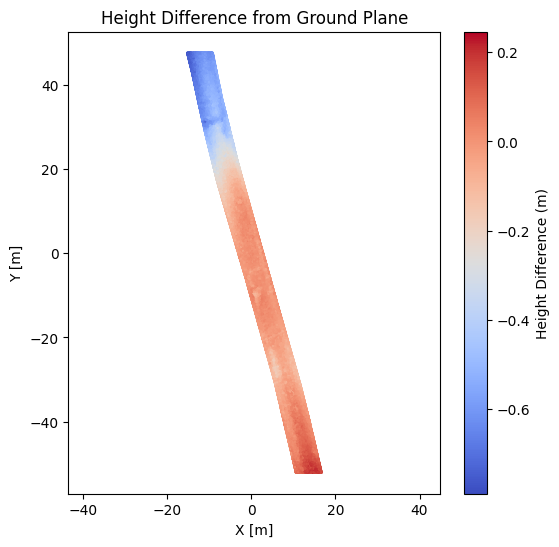

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=height_diff, cmap='coolwarm', s=0.4)
plt.title("Height Difference from Ground Plane")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.colorbar(label="Height Difference (m)")
plt.axis("equal")
plt.show()


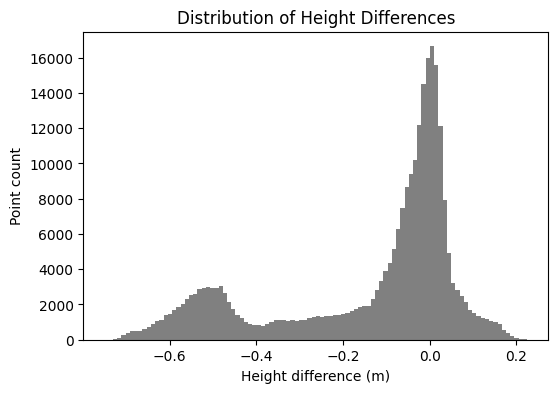

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(height_diff, bins=100, color='gray')
plt.title("Distribution of Height Differences")
plt.xlabel("Height difference (m)")
plt.ylabel("Point count")
plt.show()


Ground points: 166970
Non-ground points: 604322


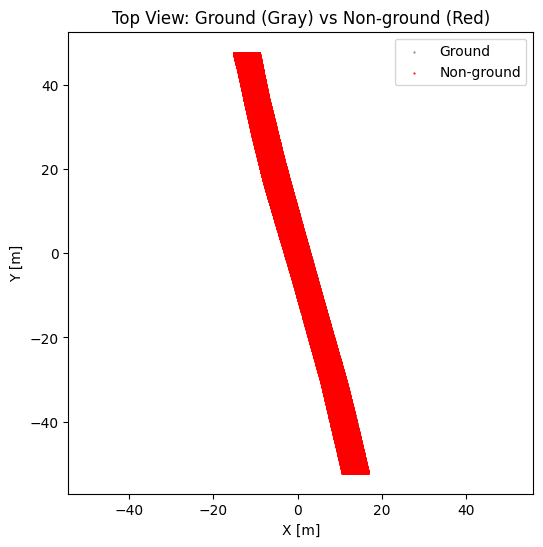

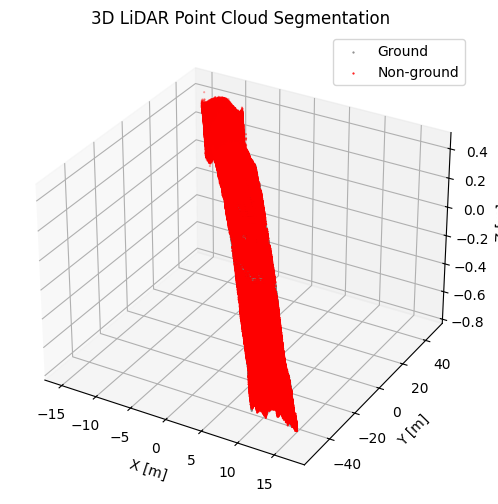

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suppose you already have:
# pcd, plane_model, inliers = o3d.geometry.PointCloud(...), ..., ...
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# Convert to NumPy arrays
ground_points = np.asarray(inlier_cloud.points)
nonground_points = np.asarray(outlier_cloud.points)

print("Ground points:", ground_points.shape[0])
print("Non-ground points:", nonground_points.shape[0])

# --- 2D Top-Down View (XY) ---
plt.figure(figsize=(6,6))
plt.scatter(ground_points[:,0], ground_points[:,1], c='gray', s=0.3, label='Ground')
plt.scatter(nonground_points[:,0], nonground_points[:,1], c='red', s=0.3, label='Non-ground')
plt.title("Top View: Ground (Gray) vs Non-ground (Red)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis('equal')
plt.show()

# --- 3D Visualization ---
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ground_points[:,0], ground_points[:,1], ground_points[:,2], c='gray', s=0.3, label='Ground')
ax.scatter(nonground_points[:,0], nonground_points[:,1], nonground_points[:,2], c='red', s=0.3, label='Non-ground')
ax.set_title("3D LiDAR Point Cloud Segmentation")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.legend()
plt.show()



**Segment 100 × 30 m Point Cloud into 5 × 5 m Tiles**

In [ ]:
import numpy as np
import os

# --- Input ---
# Assuming 'points' is your Nx3 NumPy array of (x, y, z) after centering/downsampling
# Example: points = np.asarray(pcd.points)

# Define the folder to save tiles
output_dir = "/content/tiles"
os.makedirs(output_dir, exist_ok=True)

# --- Compute grid bounds ---
x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
y_min, y_max = np.min(points[:,1]), np.max(points[:,1])

tile_size = 5.0  # meters
x_bins = np.arange(x_min, x_max + tile_size, tile_size)
y_bins = np.arange(y_min, y_max + tile_size, tile_size)

print(f"Total tiles in X: {len(x_bins)-1}, Y: {len(y_bins)-1}")
print(f"Expected tiles: {(len(x_bins)-1)*(len(y_bins)-1)}")

tile_count = 0

# --- Loop through grid and extract sub-clouds ---
for i in range(len(x_bins)-1):
    for j in range(len(y_bins)-1):
        x_min_bin, x_max_bin = x_bins[i], x_bins[i+1]
        y_min_bin, y_max_bin = y_bins[j], y_bins[j+1]

        mask = (
            (points[:,0] >= x_min_bin) & (points[:,0] < x_max_bin) &
            (points[:,1] >= y_min_bin) & (points[:,1] < y_max_bin)
        )

        tile_points = points[mask]

        if tile_points.shape[0] > 0:
            tile_name = f"tile_{i}_{j}.npy"
            np.save(os.path.join(output_dir, tile_name), tile_points)
            tile_count += 1

print(f"✅ Segmentation complete: {tile_count} tiles saved to {output_dir}")


Total tiles in X: 7, Y: 20
Expected tiles: 140
✅ Segmentation complete: 50 tiles saved to /content/tiles


**Visualize Tile Boundaries**

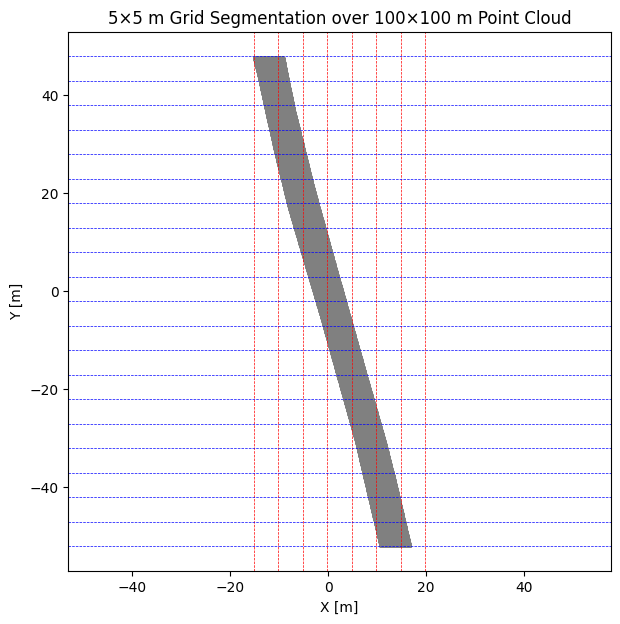

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(points[:,0], points[:,1], s=0.3, c='gray')
for xb in x_bins:
    plt.axvline(x=xb, color='r', linestyle='--', linewidth=0.5)
for yb in y_bins:
    plt.axhline(y=yb, color='b', linestyle='--', linewidth=0.5)
plt.title("5×5 m Grid Segmentation over 100×100 m Point Cloud")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.show()


**Apply RANSAC per Tile**

In [ ]:
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Input & Output Paths ---
tiles_dir = "/content/tiles"
output_dir = "/content/segmented_tiles"
os.makedirs(output_dir, exist_ok=True)

# --- RANSAC parameters (tune for your LiDAR scale) ---
distance_threshold = 0.05   # points within 5 cm of plane → ground
ransac_n = 10                # number of points used to estimate plane
num_iterations = 1000

# --- Process Each Tile ---
tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith(".npy")])
print(f"Found {len(tile_files)} tiles")

for tile_file in tile_files:
    tile_path = os.path.join(tiles_dir, tile_file)
    points = np.load(tile_path)

    # Skip tiny tiles
    if points.shape[0] < 50:
        continue

    # Convert to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # --- RANSAC Plane Fit ---
    plane_model, inliers = pcd.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )

    [a, b, c, d] = plane_model
    inlier_cloud = pcd.select_by_index(inliers)
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    # Convert back to NumPy arrays
    ground_points = np.asarray(inlier_cloud.points)
    nonground_points = np.asarray(outlier_cloud.points)

    # Save segmented results
    np.save(os.path.join(output_dir, tile_file.replace(".npy", "_ground.npy")), ground_points)
    np.save(os.path.join(output_dir, tile_file.replace(".npy", "_nonground.npy")), nonground_points)

print("✅ Ground / non-ground segmentation completed for all tiles.")


Found 50 tiles
✅ Ground / non-ground segmentation completed for all tiles.


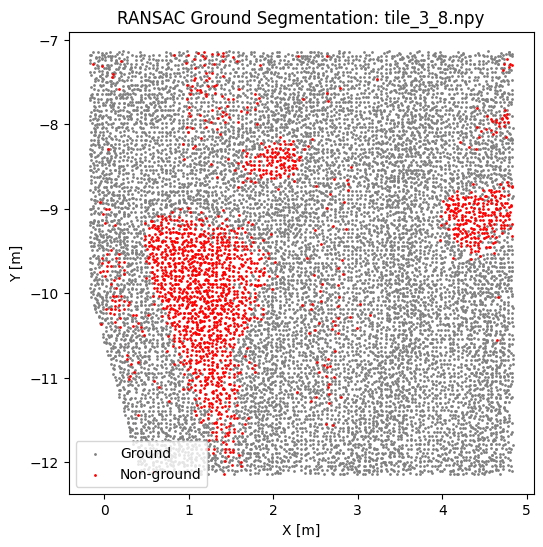

In [ ]:
# Pick a sample tile to visualize
sample_tile = tile_files[30]
ground = np.load(os.path.join(output_dir, sample_tile.replace(".npy", "_ground.npy")))
nonground = np.load(os.path.join(output_dir, sample_tile.replace(".npy", "_nonground.npy")))

plt.figure(figsize=(6,6))
plt.scatter(ground[:,0], ground[:,1], s=1, c='gray', label='Ground')
plt.scatter(nonground[:,0], nonground[:,1], s=1, c='red', label='Non-ground')
plt.title(f"RANSAC Ground Segmentation: {sample_tile}")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.legend(); plt.axis("equal"); plt.show()


**Threshold-based Crack/Pothole Detection**

In [ ]:
crack_mask = height_diff < -0.02  # 2 cm below plane
pothole_mask = height_diff < -0.05  # 5 cm below plane

print("Crack points:", np.sum(crack_mask))
print("Pothole points:", np.sum(pothole_mask))


Crack points: 197078
Pothole points: 154911


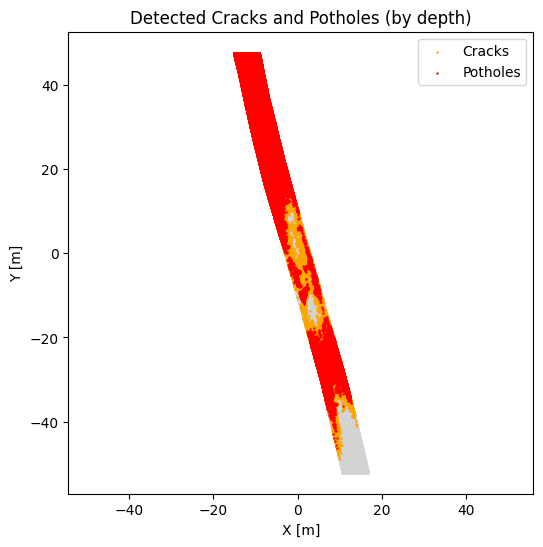

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=0.3, c='lightgray')
plt.scatter(points[crack_mask,0], points[crack_mask,1], s=0.5, c='orange', label='Cracks')
plt.scatter(points[pothole_mask,0], points[pothole_mask,1], s=0.5, c='red', label='Potholes')
plt.legend()
plt.title("Detected Cracks and Potholes (by depth)")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.axis("equal")
plt.show()


In [ ]:
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Input/output directories ---
tiles_dir = "/content/tiles"
output_dir = "/content/detected_tiles"
os.makedirs(output_dir, exist_ok=True)

# --- Parameters ---
distance_threshold = 0.03   # RANSAC fit tolerance (m)
ransac_n = 3
num_iterations = 1000
crack_thresh = -0.02         # below plane by >2 cm → crack
pothole_thresh = -0.05       # below plane by >5 cm → pothole

tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith(".npy")])
print(f"Found {len(tile_files)} tiles")

for tile_file in tile_files:
    points = np.load(os.path.join(tiles_dir, tile_file))
    if points.shape[0] < 50:
        continue

    # --- Fit ground plane using RANSAC ---
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    plane_model, inliers = pcd.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )
    a, b, c, d = plane_model

    # --- Compute height difference from plane ---
    distances = (a * points[:,0] + b * points[:,1] + c * points[:,2] + d) / np.sqrt(a**2 + b**2 + c**2)

    # --- Identify cracks and potholes ---
    crack_mask = distances < crack_thresh
    pothole_mask = distances < pothole_thresh

    crack_points = points[crack_mask]
    pothole_points = points[pothole_mask]

    # --- Save results ---
    np.save(os.path.join(output_dir, tile_file.replace(".npy", "_cracks.npy")), crack_points)
    np.save(os.path.join(output_dir, tile_file.replace(".npy", "_potholes.npy")), pothole_points)

    print(f"{tile_file}: Crack points={len(crack_points)}, Pothole points={len(pothole_points)}")

print("✅ Detection completed for all tiles.")


Found 50 tiles
tile_0_15.npy: Crack points=26, Pothole points=0
tile_0_16.npy: Crack points=281, Pothole points=11
tile_0_17.npy: Crack points=482, Pothole points=5
tile_0_18.npy: Crack points=809, Pothole points=7
tile_0_19.npy: Crack points=1804, Pothole points=298
tile_1_12.npy: Crack points=221, Pothole points=9
tile_1_13.npy: Crack points=947, Pothole points=68
tile_1_14.npy: Crack points=1823, Pothole points=18
tile_1_15.npy: Crack points=4907, Pothole points=1870
tile_1_16.npy: Crack points=3149, Pothole points=1123
tile_1_17.npy: Crack points=2889, Pothole points=712
tile_1_18.npy: Crack points=796, Pothole points=28
tile_1_19.npy: Crack points=128, Pothole points=3
tile_2_10.npy: Crack points=656, Pothole points=19
tile_2_11.npy: Crack points=1983, Pothole points=37
tile_2_12.npy: Crack points=3157, Pothole points=834
tile_2_13.npy: Crack points=2466, Pothole points=585
tile_2_14.npy: Crack points=1613, Pothole points=270
tile_2_15.npy: Crack points=304, Pothole points=7
tile_

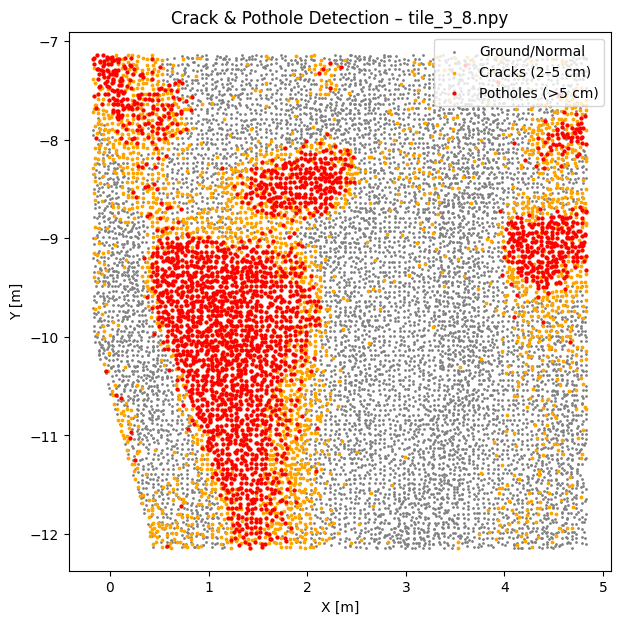

In [ ]:
# Pick a sample tile to visualize
sample_tile = tile_files[30]
points = np.load(os.path.join(tiles_dir, sample_tile))
crack_points = np.load(os.path.join(output_dir, sample_tile.replace(".npy", "_cracks.npy")))
pothole_points = np.load(os.path.join(output_dir, sample_tile.replace(".npy", "_potholes.npy")))

plt.figure(figsize=(7,7))
plt.scatter(points[:,0], points[:,1], s=1, c='gray', label='Ground/Normal')
plt.scatter(crack_points[:,0], crack_points[:,1], s=3, c='orange', label='Cracks (2–5 cm)')
plt.scatter(pothole_points[:,0], pothole_points[:,1], s=4, c='red', label='Potholes (>5 cm)')
plt.title(f"Crack & Pothole Detection – {sample_tile}")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.legend()
plt.show()


Semi-automatic Labeling

In [ ]:
labels = np.zeros(len(points))
labels[height_diff < -0.02] = 1   # potential crack
labels[height_diff < -0.05] = 2   # deeper pothole
